In [22]:

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from torchsummary import summary
from tabulate import tabulate
%matplotlib inline

In [23]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Image

In [24]:
image_path="/kaggle/input/golden-foot-football-players-image-dataset/football_golden_foot/football_golden_foot/"

# Visualize Images

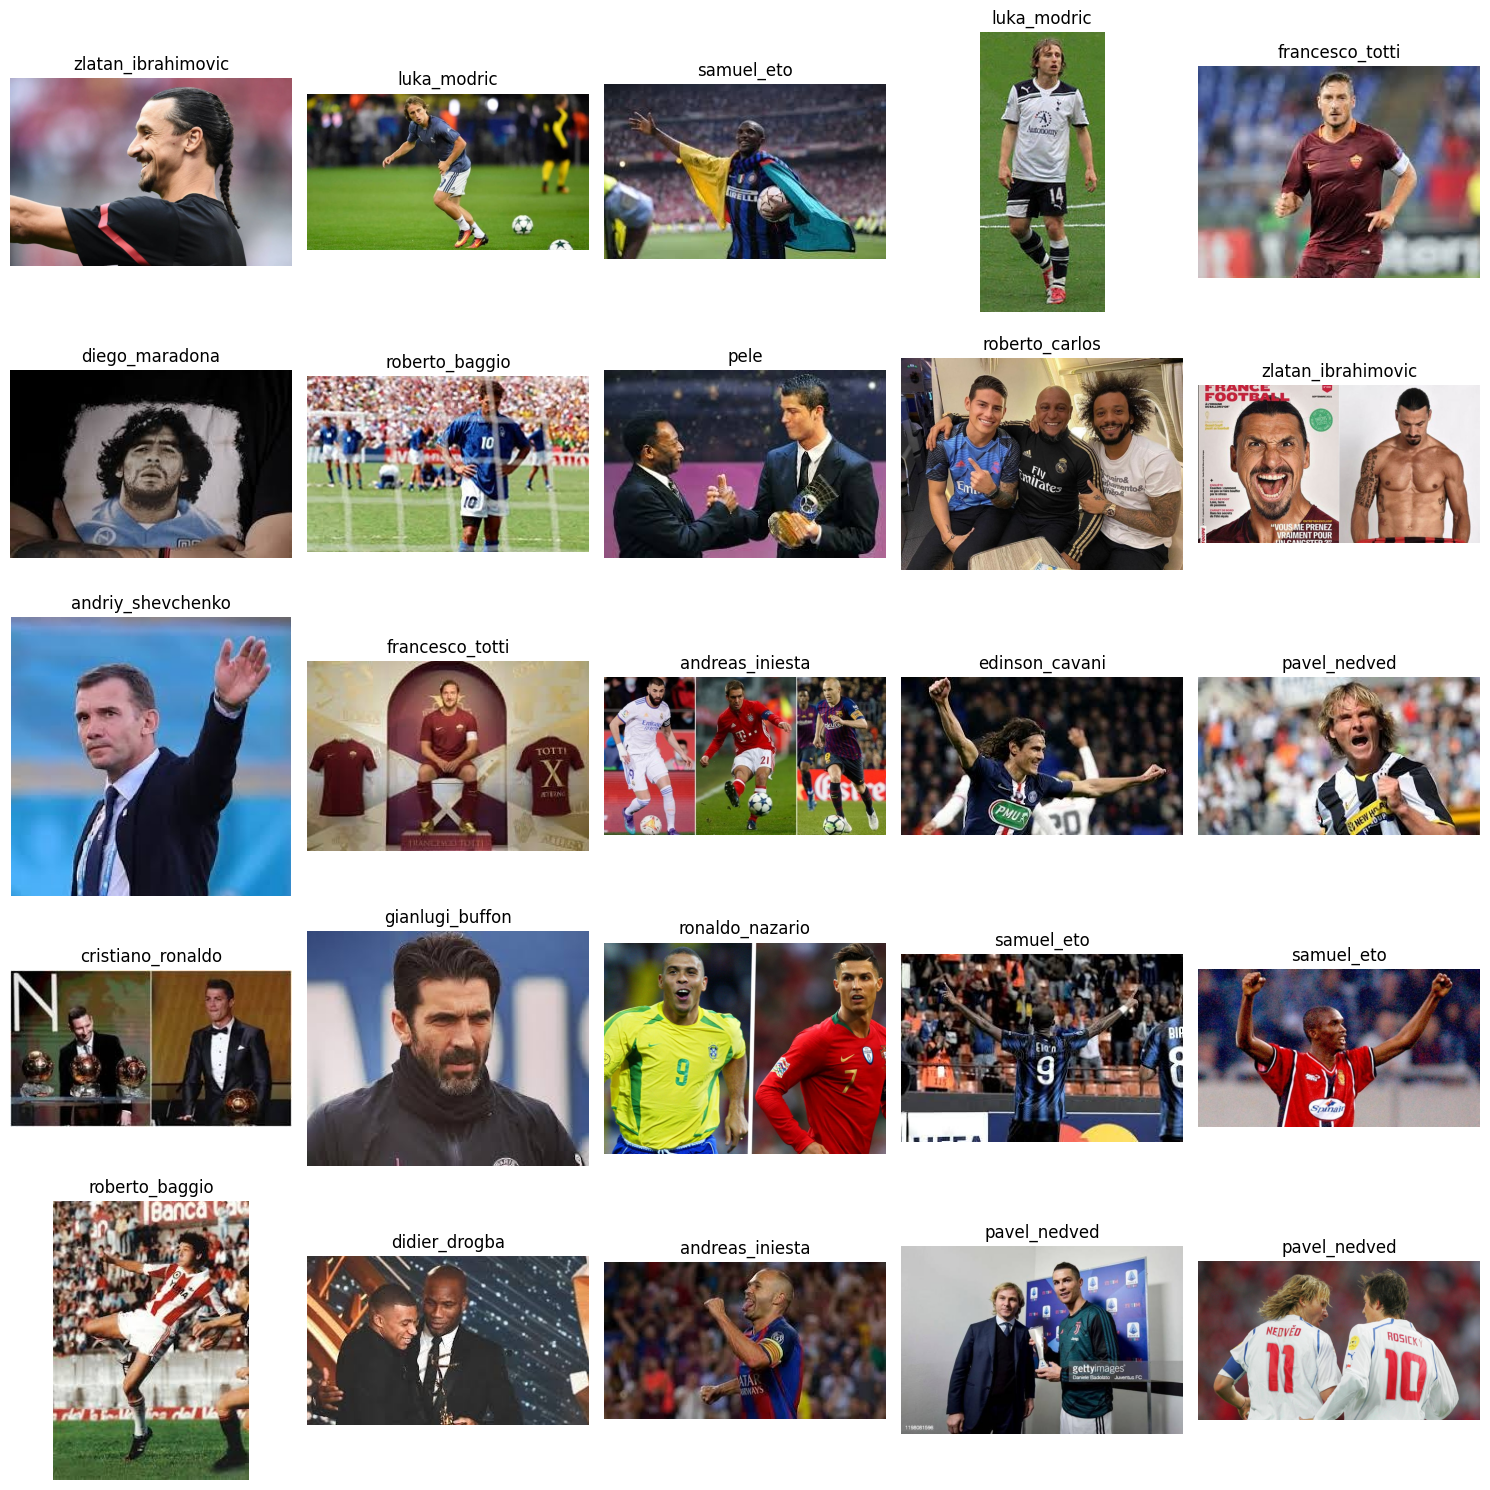

In [25]:
# List all directories (player names) in the dataset
players = os.listdir(image_path)

# Initialize a figure for plotting the images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Select 25 random images from the dataset and plot them
for i in range(25):
    # Randomly select a player
    player = random.choice(players)
    
    # Get a list of image files for that player
    player_images = os.listdir(os.path.join(image_path, player))
    
    # Randomly select an image file for the player
    img_file = random.choice(player_images)
    
    # Load the image
    img = Image.open(os.path.join(image_path, player, img_file))
    
    # Display the image in the grid
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes for better clarity
    axes[i].set_title(player)  # Set the player name as the title

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.show()

# Compare Each Class Length

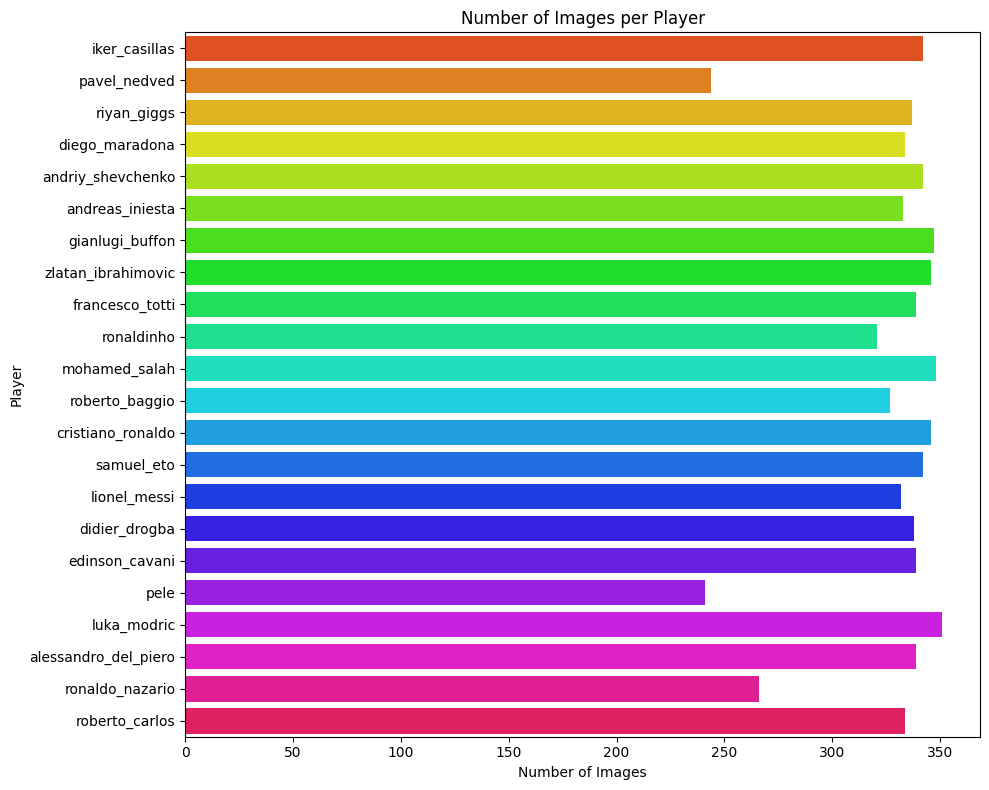

In [26]:
# List all directories (player names) in the dataset
players = os.listdir(image_path)

# Count the number of images for each player
image_counts = [len(os.listdir(os.path.join(image_path, player))) for player in players]

# Create a DataFrame for plotting
import pandas as pd
data = pd.DataFrame({'Player': players,'Image Count': image_counts})

# Set up the seaborn plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Image Count', y='Player', data=data, palette="hsv")

# Set plot labels and title
plt.xlabel('Number of Images')
plt.ylabel('Player')
plt.title('Number of Images per Player')

# Show the plot
plt.tight_layout()
plt.show()

# Find Label Name

In [27]:
label_names=os.listdir(image_path)
label_names=[label for label in label_names if os.path.isdir(os.path.join(image_path,label))]
print(f"Label Names : {label_names}")

Label Names : ['iker_casillas', 'pavel_nedved', 'riyan_giggs', 'diego_maradona', 'andriy_shevchenko', 'andreas_iniesta', 'gianlugi_buffon', 'zlatan_ibrahimovic', 'francesco_totti', 'ronaldinho', 'mohamed_salah', 'roberto_baggio', 'cristiano_ronaldo', 'samuel_eto', 'lionel_messi', 'didier_drogba', 'edinson_cavani', 'pele', 'luka_modric', 'alessandro_del_piero', 'ronaldo_nazario', 'roberto_carlos']


# Load Image & Labels

In [28]:
images=[]
labels=[]

for label in tqdm(label_names):
    class_path=os.path.join(image_path,label)
    for filename in os.listdir(class_path):
        img_path=os.path.join(class_path,filename)
        img=cv2.imread(img_path)
        img=cv2.resize(img,(150,150))
        images.append(img)
        labels.append(label_names.index(label))


images=np.array(images)
labels=np.array(labels)

100%|██████████| 22/22 [00:23<00:00,  1.09s/it]


In [29]:
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.4, stratify=labels, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape : {Y_train.shape}")
print(f"Y_valid shape : {Y_valid.shape}")
print(f"Y_test shape : {Y_test.shape}")

X_train shape: (4312, 150, 150, 3)
X_valid shape: (1438, 150, 150, 3)
X_test shape: (1438, 150, 150, 3)
Y_train shape : (4312,)
Y_valid shape : (1438,)
Y_test shape : (1438,)


# Setup our Data Processing - Create our Image Pairs

In [30]:


# Define the transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 100x100
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images to [-1, 1]
])

# Create dataset

In [31]:

class SiameseNetworkDataset(Dataset):
    def __init__(self, images, labels, transform=None, should_invert=False):
        """
        Args:
            images (list): List of images in numpy array format.
            labels (list): Corresponding labels for the images.
            transform: Image transformation (e.g., normalization, resizing).
            should_invert (bool): Whether to invert images.
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self, index):
        img0 = self.images[index]
        img0_label = self.labels[index]

        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                idx = random.randint(0, len(self.images) - 1)
                if self.labels[idx] == img0_label:
                    img1 = self.images[idx]
                    img1_label = self.labels[idx]
                    break
        else:
            while True:
                idx = random.randint(0, len(self.images) - 1)
                if self.labels[idx] != img0_label:
                    img1 = self.images[idx]
                    img1_label = self.labels[idx]
                    break

        # Invert images if needed
        if self.should_invert:
            img0 = PIL.ImageOps.invert(Image.fromarray(img0))
            img1 = PIL.ImageOps.invert(Image.fromarray(img1))

        # Convert numpy arrays to PIL images if needed
        img0 = Image.fromarray(img0).convert("RGB")
        img1 = Image.fromarray(img1).convert("RGB")

        # Apply transformations if specified
        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Label 1 if they are the same class, 0 otherwise
        label = torch.tensor([int(img0_label != img1_label)], dtype=torch.float32)

        return img0, img1, label

    def __len__(self):
        return len(self.images)






# Creating datasets using the predefined splits

In [32]:


train_dataset = SiameseNetworkDataset(X_train, Y_train, transform=transform)
valid_dataset = SiameseNetworkDataset(X_valid, Y_valid, transform=transform)
test_dataset = SiameseNetworkDataset(X_test, Y_test, transform=transform)


# Create DataLoader

In [33]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=32,shuffle=False)

In [34]:
image0, image1, label = next(iter(train_loader))

print(f"Image0 shape: {image0.shape}")
print(f"Image1 shape: {image1.shape}")
print(f"Label shape: {label.shape}")


Image0 shape: torch.Size([32, 3, 150, 150])
Image1 shape: torch.Size([32, 3, 150, 150])
Label shape: torch.Size([32, 1])


# Build Model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Convolutional feature extractor
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample
        )

        # Fully connected layers for feature embedding
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 18 * 18, 1024),  # Adjusted for 150x150 input size
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout for regularization

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 128),  # Smaller embedding space
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size(0), -1)  # Flatten
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


# Model initialization and device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)

# Print model summary
from torchsummary import summary
summary(model, input_size=[(3, 150, 150), (3, 150, 150)])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
              ReLU-2         [-1, 32, 150, 150]               0
       BatchNorm2d-3         [-1, 32, 150, 150]              64
            Conv2d-4         [-1, 64, 150, 150]          18,496
              ReLU-5         [-1, 64, 150, 150]               0
       BatchNorm2d-6         [-1, 64, 150, 150]             128
         MaxPool2d-7           [-1, 64, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]          73,856
              ReLU-9          [-1, 128, 75, 75]               0
      BatchNorm2d-10          [-1, 128, 75, 75]             256
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
      BatchNorm2d-13          [-1, 256, 75, 75]             512
        MaxPool2d-14          [-1, 256,

# Define Loss Function

In [36]:
class LossFunction(nn.Module):
    def __init__(self, margin=2.0):
        super(LossFunction, self).__init__()
        self.margin = margin  # Store margin as an attribute

    def forward(self, output1, output2, label):
        # Compute the Euclidean distance between the outputs
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)

        # Contrastive loss
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + 
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss

# Loss & Optimizer

In [37]:

criterion = LossFunction()
optimizer = optim.Adam(model.parameters(),lr = 0.0005 )

# Helper function to calculate accuracy


In [38]:
def calculate_accuracy(output1,output2,label):
    euclidean_distance=F.pairwise_distance(output1,output2,keepdim=True)
    predicted=(euclidean_distance<1.0).float()
    correct=(predicted==label).sum().item()
    total=label.size(0)
    accuracy=correct/total*100
    return accuracy


epoch = 10  # Set the number of epochs
Config = {
    'train_number_epochs': epoch,
    'learning_rate': 0.0005,
}

# Train & Validation Loop

In [39]:
# Initialize history lists for tracking metrics
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Training and Validation Loop
for epoch_num in range(1, Config['train_number_epochs'] + 1):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Train Loop
    with tqdm(train_loader, desc=f"Epoch {epoch_num}/{Config['train_number_epochs']}", unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            optimizer.zero_grad()  # Zero out the gradients
            
            # Forward pass
            output1, output2 = model(img0, img1)
            
            # Calculate loss
            loss = criterion(output1, output2, label)
            loss.backward()  # Backward pass
            
            # Update weights
            optimizer.step()
            
            # Track training loss and accuracy
            train_loss += loss.item()
            acc = calculate_accuracy(output1, output2, label)
            
            # Convert accuracy percentage to count
            batch_size = label.size(0)
            train_correct += (acc * batch_size / 100.0)
            train_total += batch_size
            
            # Store the accuracy percentage
            train_acc_history.append(acc)
            
            # Update the progress bar
            tepoch.set_postfix(loss=loss.item(), accuracy=acc)
    
    # Average training loss and accuracy for the epoch
    avg_train_loss = train_loss / len(train_loader)
    avg_train_accuracy = (train_correct / train_total) * 100
    train_loss_history.append(avg_train_loss)
    
    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # No gradients needed for validation
        for data in valid_loader:
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            # Forward pass
            output1, output2 = model(img0, img1)
            
            # Calculate loss
            loss = criterion(output1, output2, label)
            val_loss += loss.item()
            
            # Calculate accuracy
            acc = calculate_accuracy(output1, output2, label)
            
            # Convert accuracy percentage to count
            batch_size = label.size(0)
            val_correct += (acc * batch_size / 100.0)
            val_total += batch_size
            
            # Store the accuracy percentage
            val_acc_history.append(acc)
    
    # Average validation loss and accuracy for the epoch
    avg_val_loss = val_loss / len(valid_loader)
    avg_val_accuracy = (val_correct / val_total) * 100
    val_loss_history.append(avg_val_loss)
    
    # Display results
    print(f"\nEpoch {epoch_num}/{Config['train_number_epochs']}:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.2f}%")

    # Display a table with results for this epoch
    results = [
        ['Train Loss', avg_train_loss],
        ['Train Accuracy', avg_train_accuracy],
        ['Validation Loss', avg_val_loss],
        ['Validation Accuracy', avg_val_accuracy]
    ]
    
    print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid"))

Epoch 1/10: 100%|██████████| 135/135 [00:36<00:00,  3.73batch/s, accuracy=62.5, loss=1.74]



Epoch 1/10:
Train Loss: 7.4001, Train Accuracy: 50.86%
Validation Loss: 2.0291, Validation Accuracy: 51.46%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  7.40012 |
+---------------------+----------+
| Train Accuracy      | 50.8581  |
+---------------------+----------+
| Validation Loss     |  2.02914 |
+---------------------+----------+
| Validation Accuracy | 51.4604  |
+---------------------+----------+


Epoch 2/10: 100%|██████████| 135/135 [00:36<00:00,  3.74batch/s, accuracy=62.5, loss=2.65] 



Epoch 2/10:
Train Loss: 1.8029, Train Accuracy: 49.23%
Validation Loss: 1.9340, Validation Accuracy: 48.40%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  1.80295 |
+---------------------+----------+
| Train Accuracy      | 49.2347  |
+---------------------+----------+
| Validation Loss     |  1.93404 |
+---------------------+----------+
| Validation Accuracy | 48.4006  |
+---------------------+----------+


Epoch 3/10: 100%|██████████| 135/135 [00:36<00:00,  3.74batch/s, accuracy=54.2, loss=2.31]



Epoch 3/10:
Train Loss: 2.0089, Train Accuracy: 50.37%
Validation Loss: 1.9694, Validation Accuracy: 50.00%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  2.00888 |
+---------------------+----------+
| Train Accuracy      | 50.3711  |
+---------------------+----------+
| Validation Loss     |  1.96944 |
+---------------------+----------+
| Validation Accuracy | 50       |
+---------------------+----------+


Epoch 4/10: 100%|██████████| 135/135 [00:36<00:00,  3.74batch/s, accuracy=45.8, loss=1.76]



Epoch 4/10:
Train Loss: 1.9670, Train Accuracy: 51.02%
Validation Loss: 1.3963, Validation Accuracy: 49.03%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  1.96698 |
+---------------------+----------+
| Train Accuracy      | 51.0204  |
+---------------------+----------+
| Validation Loss     |  1.39634 |
+---------------------+----------+
| Validation Accuracy | 49.0264  |
+---------------------+----------+


Epoch 5/10: 100%|██████████| 135/135 [00:36<00:00,  3.72batch/s, accuracy=45.8, loss=1]    



Epoch 5/10:
Train Loss: 1.4834, Train Accuracy: 50.58%
Validation Loss: 1.3481, Validation Accuracy: 46.59%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  1.48342 |
+---------------------+----------+
| Train Accuracy      | 50.5798  |
+---------------------+----------+
| Validation Loss     |  1.34811 |
+---------------------+----------+
| Validation Accuracy | 46.5925  |
+---------------------+----------+


Epoch 6/10: 100%|██████████| 135/135 [00:36<00:00,  3.71batch/s, accuracy=33.3, loss=0.851]



Epoch 6/10:
Train Loss: 1.3917, Train Accuracy: 48.68%
Validation Loss: 1.3787, Validation Accuracy: 48.26%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  1.39172 |
+---------------------+----------+
| Train Accuracy      | 48.6781  |
+---------------------+----------+
| Validation Loss     |  1.37869 |
+---------------------+----------+
| Validation Accuracy | 48.2615  |
+---------------------+----------+


Epoch 7/10: 100%|██████████| 135/135 [00:36<00:00,  3.73batch/s, accuracy=66.7, loss=1.71] 



Epoch 7/10:
Train Loss: 1.3690, Train Accuracy: 48.72%
Validation Loss: 1.3727, Validation Accuracy: 50.14%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  1.36902 |
+---------------------+----------+
| Train Accuracy      | 48.7245  |
+---------------------+----------+
| Validation Loss     |  1.37267 |
+---------------------+----------+
| Validation Accuracy | 50.1391  |
+---------------------+----------+


Epoch 8/10: 100%|██████████| 135/135 [00:36<00:00,  3.74batch/s, accuracy=66.7, loss=1.98]



Epoch 8/10:
Train Loss: 1.3793, Train Accuracy: 47.66%
Validation Loss: 1.3591, Validation Accuracy: 48.40%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  1.3793  |
+---------------------+----------+
| Train Accuracy      | 47.6577  |
+---------------------+----------+
| Validation Loss     |  1.35908 |
+---------------------+----------+
| Validation Accuracy | 48.4006  |
+---------------------+----------+


Epoch 9/10: 100%|██████████| 135/135 [00:36<00:00,  3.74batch/s, accuracy=33.3, loss=0.766]



Epoch 9/10:
Train Loss: 1.3878, Train Accuracy: 46.89%
Validation Loss: 1.2542, Validation Accuracy: 46.52%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  1.38783 |
+---------------------+----------+
| Train Accuracy      | 46.8924  |
+---------------------+----------+
| Validation Loss     |  1.25421 |
+---------------------+----------+
| Validation Accuracy | 46.5229  |
+---------------------+----------+


Epoch 10/10: 100%|██████████| 135/135 [00:36<00:00,  3.74batch/s, accuracy=41.7, loss=1.01] 



Epoch 10/10:
Train Loss: 1.3328, Train Accuracy: 46.61%
Validation Loss: 1.3205, Validation Accuracy: 47.98%
+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Train Loss          |  1.33277 |
+---------------------+----------+
| Train Accuracy      | 46.6141  |
+---------------------+----------+
| Validation Loss     |  1.32054 |
+---------------------+----------+
| Validation Accuracy | 47.9833  |
+---------------------+----------+


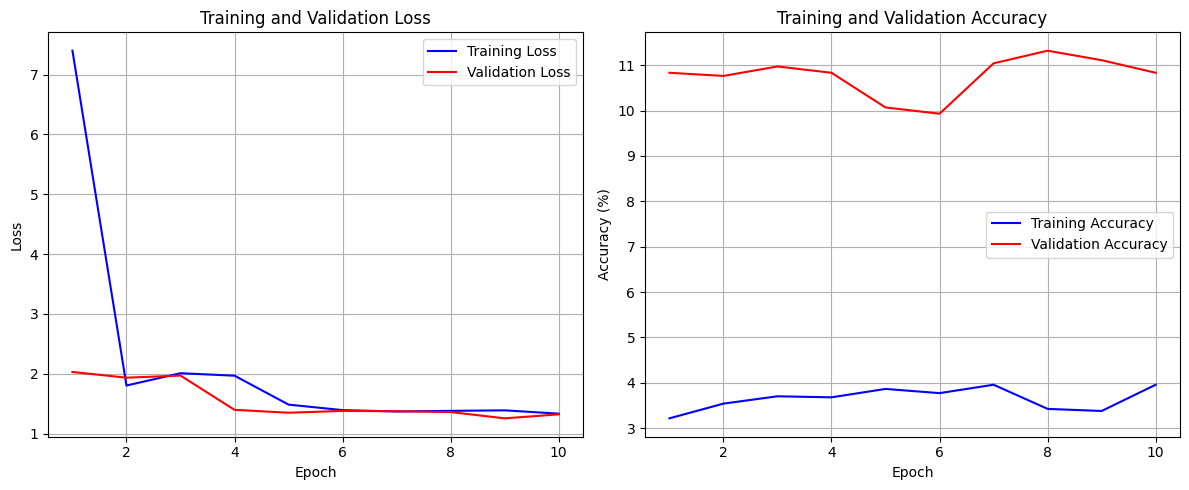

In [40]:
# Plotting Loss and Accuracy
epochs = range(1, len(train_loss_history) + 1)  # Epochs completed

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
avg_train_acc_per_epoch = [sum(train_acc_history[i::len(train_loader)]) / len(train_loader) 
                          for i in range(len(train_loader))]  # Average accuracy per epoch
avg_val_acc_per_epoch = [sum(val_acc_history[i::len(valid_loader)]) / len(valid_loader) 
                        for i in range(len(valid_loader))]    # Average accuracy per epoch

plt.plot(epochs, avg_train_acc_per_epoch[:len(epochs)], 'b-', label='Training Accuracy')
plt.plot(epochs, avg_val_acc_per_epoch[:len(epochs)], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# View our Test Results

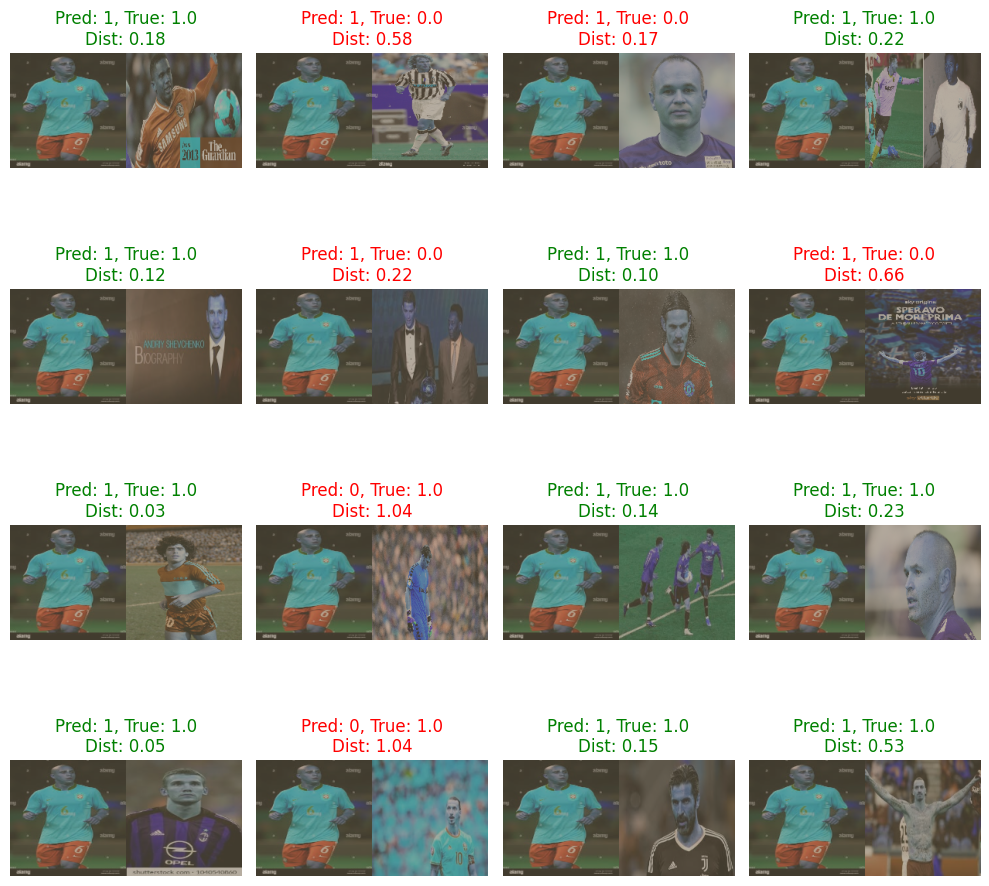

In [41]:

# Define a plotting function
def imshow(img, title, color='black'):
    """Helper function to display an image with a colored title."""
    img = img.cpu().numpy()
    
    if img.shape[0] == 6:  # If 6 channels, take only the first 3 (RGB)
        img = img[:3]  
    
    img = img.transpose((1, 2, 0))  # Convert from tensor [C, H, W] to numpy [H, W, C]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Ensure values are in range [0,1]
    
    plt.imshow(img)
    plt.title(title, color=color)
    plt.axis('off')

# Load test data
dataiter = iter(test_loader)
x0, _, _ = next(dataiter)


# Select a single reference image
x0_single = x0[0]  # [3, 150, 150]

# Set up the 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

threshold = 1.0  # Distance threshold for similarity
pair_index = 0

# Plot 16 image pairs (4x4 grid)
for i in range(16):
    if pair_index == 0:  # Fetch a new batch when needed
        _, x1_batch, label2_batch = next(dataiter)
       

    # Select one image pair
    x1_single = x1_batch[pair_index]  # [3, 150, 150]
    label2_single = label2_batch[pair_index]  # Scalar label
    
    pair_index = (pair_index + 1) % 32  # Cycle through batch

    # Forward pass through the network
    x0_input = x0_single.unsqueeze(0).cuda()
    x1_input = x1_single.unsqueeze(0).cuda()
    
    output1, output2 = model(Variable(x0_input), Variable(x1_input))
  

    # Compute Euclidean distance
    euclidean_distance = F.pairwise_distance(output1, output2).item()

    # Predict label based on threshold
    predicted_label = 1 if euclidean_distance < threshold else 0
    true_label = label2_single.item()

    # Set title color (green if correct, red if incorrect)
    title_color = 'green' if predicted_label == true_label else 'red'
    title = f"Pred: {predicted_label}, True: {true_label}\nDist: {euclidean_distance:.2f}"

    # Stack images side by side along width
    concatenated = torch.cat((x0_single, x1_single), dim=2)  # [3, 150, 300]

    # Plot image
    plt.sca(axes[i])  # Set current axis
    imshow(concatenated, title, color=title_color)

# Adjust layout and display
plt.tight_layout()
plt.show()
